# Correction of telescope polarisation for ZIMPOL data

*translation of HMS idl 'PolAperUMon.pro' script to python*
It fully works for U Mon and gives the same result as HMS.




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
import pandas as pd
from scipy.signal import convolve2d
from scipy.signal import convolve, oaconvolve
from PIL import Image, ImageChops
import sys
import math
import seaborn as sns
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.modeling.models import Lorentz1D
from astropy.convolution import convolve_fft
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from skimage.transform import rescale, resize, downscale_local_mean

def load_files(dirdat,process):
    dir = dirdat
    qfile = str(process)+'*'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdul = fits.open(dir + file)
            iq = hdul[0].data[0]
            q = hdul[0].data[1]
            iu = hdul[0].data[2]
            u = hdul[0].data[3]
            n=q.shape[0]   
            time=str(hdul[0].header['DATE-OBS'])
            parang_deg_mean=(hdul[0].header['HIERARCH ESO TEL PARANG END']+hdul[0].header['HIERARCH ESO TEL PARANG START'])/2
    return iq,q,iu,u,time, file, parang_deg_mean



def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   



In [2]:
# Aperture polarimetry for U Mon
 # ------------------------------

# Katya: itelcor=0 - plot figure with "before" and 'after';
# Katya: itelcor=1 - no fig, performs correction for the telescope polarisation and save fits     
    
# apply correction
itelcor = 0
# no telescope polarization and then search for telescope polarization
# itelcor = 0
# data are corrected for telescope polarization
# and for an offset
# itelcor = 1
# different cases (uncomment)

# only telescope polarization
# qcorr_cyc*, ucorr_cyc*
# qphi_cyc*, uphi_cyc*
q1off = 0.0/100.
u1off = 0.0/100.
q2off = 0.0/100.
u2off = 0.0/100.

# telescope polarization and then normalization
# (subtract integrated polarization)
# qcorrn_cyc*, ucorrn_cyc*
# qphin_cyc*,uphin_cyc
# these are the values for the integrated polarization
#q1off = 1.07/100.
#u1off = 0.32/100.
#q2off = 1.16/100.
#u2off = 0.21/100.

# other cases
# qcorrx_cyc*, ucorrx_cyc*
# offset for PSF peak 0-3 pixels
#q1off = +1.00/100.
#u1off = -0.58/100.
#q2off = +1.21/100.
#u2off = -0.47/100.
# try and error
#q1off = +1.00/100.
#u1off = 0.0/100.
#q2off = +1.00/100.
#u2off = +0.5/100.

# produce new output data
ifileout = 0
# 0 - no output fits
# 1 - q,u,qphi,uphi
# 2 - pi


# produce qcorr and ucorr files 
# produce qphi and uphi files
# - for itelcor = 0
#      --> qphi and uphi frames of the original files
#      --> qcorr and ucorr is identical to the input q and u
#
# ifileout gives pi1 and pi2 files



#use this ONLY if ifileout=0
#for AR Pup
#rin_list=[0,0,0,0,0,0,10,20,30,20,20,20]
#rout_list=[3,5,10,20,30,300,300,300,300,100,200]

#for IRAS08
#rin_list=[0,0,0,0,0,0,5,10,20,10,10]
#rout_list=[3,5,10,20,30,300,300,300,300,100,200]

#for ref IRAS08
rin_list=[0]
rout_list=[300]

print(len(rin_list))
print(len(rout_list))
#rin_list=[0]
#rout_list=[300]



# Define the filenames, parang values, and folder

#star='HD75885' #ref for AR Pup
#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/' 
#input_filename =dirdat+'process_list.csv'

#star='HD83878' #ref for IRAS08
#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/HD83878/' 
#input_filename =dirdat+'process_list.csv'


#star='IRAS08544-4431_dc_notnorm'
#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
#input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'

#star='IRAS08544-4431'
#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
#input_filename =dirdat+'IRAS08process_list.csv'

#star='AR_Pup_dc_notnorm'
#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
#input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'#



#after frame selection!
#only change star
stars=['HR4049_20190108','HR4049_20190107','V709_Car','HR4226','UMon_Katya']
stars=['HR4049_combined']


#star='IRAS08544-4431_dc_notnorm'

starnames = {"HR4049_combined":'HR4049','HD75885':'HD75885','AR_Pup_dc_notnorm':'AR Pup','HR4049_20190108':'HR4049/2019-01-08','HR4049_20190107':'HR4049/2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'U Mon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709 Car','UMon_calibV390':'UMon_calibV390','HR4226':'HR4226','UMon_Katya':'U Mon'}

#stars=['HD83878','IRAS08544-4431_dc_notnorm','HD75885', 'AR_Pup_dc_notnorm','UMon','HR4049_20190108','HR4049_20190107','HD71253','HD94680','HD96314','HD98025','V709_Car','HR4226']
stars_type={'HR4049_combined':'sci','HD83878':'ref','IRAS08544-4431_dc_notnorm':'sci','HD75885':'ref', 'AR_Pup_dc_notnorm':'sci','UMon_Katya':'sci','UMon':'sci','HR4049_20190108':'sci','HR4049_20190107':'sci','HD71253':'ref','HD94680':'ref','HD96314':'ref','HD98025':'ref','V709_Car':'sci','HR4226':'sci'}
#start from 5
#star=stars[12]


1
1





{'HR4049_20190107_18c_07_38-39(2)_not_norm': 573542, 'HR4049_20190107_14c_07_30-31_not_norm': 573538, 'HR4049_20190107_11c_07_24-26(1)_not_norm': 573535, 'HR4049_20190107_10c_07_23-24(1)_not_norm': 573534, 'HR4049_20190107_9c_07_21-22_not_norm': 573533, 'HR4049_20190107_8c_07_19-20_not_norm': 573532, 'HR4049_20190107_7c_07_17-18_not_norm': 573531, 'HR4049_20190107_6c_07_15-16_not_norm': 573530, 'HR4049_20190107_5c_07_13-15(1)_not_norm': 573529, 'HR4049_20190107_3c_07_09-11(1)_not_norm': 573527, 'HR4049_20190108_20c_07_42-44_not_norm': 573518, 'HR4049_20190108_19c_07_40-42(1)_not_norm': 573517, 'HR4049_20190108_18c_07_39-40(2)_not_norm': 573516, 'HR4049_20190108_17c_07_37-38_not_norm': 573515, 'HR4049_20190108_14c_07_31-32_not_norm': 573512, 'HR4049_20190108_13c_07_29-31(1)_not_norm': 573511, 'HR4049_20190108_12c_07_27-29(1)_not_norm': 573510, 'HR4049_20190108_11c_07_25-27(1)_not_norm': 573509, 'HR4049_20190108_10c_07_24-25(1)_not_norm': 573508, 'HR4049_20190108_9c_07_22-23_not_norm'

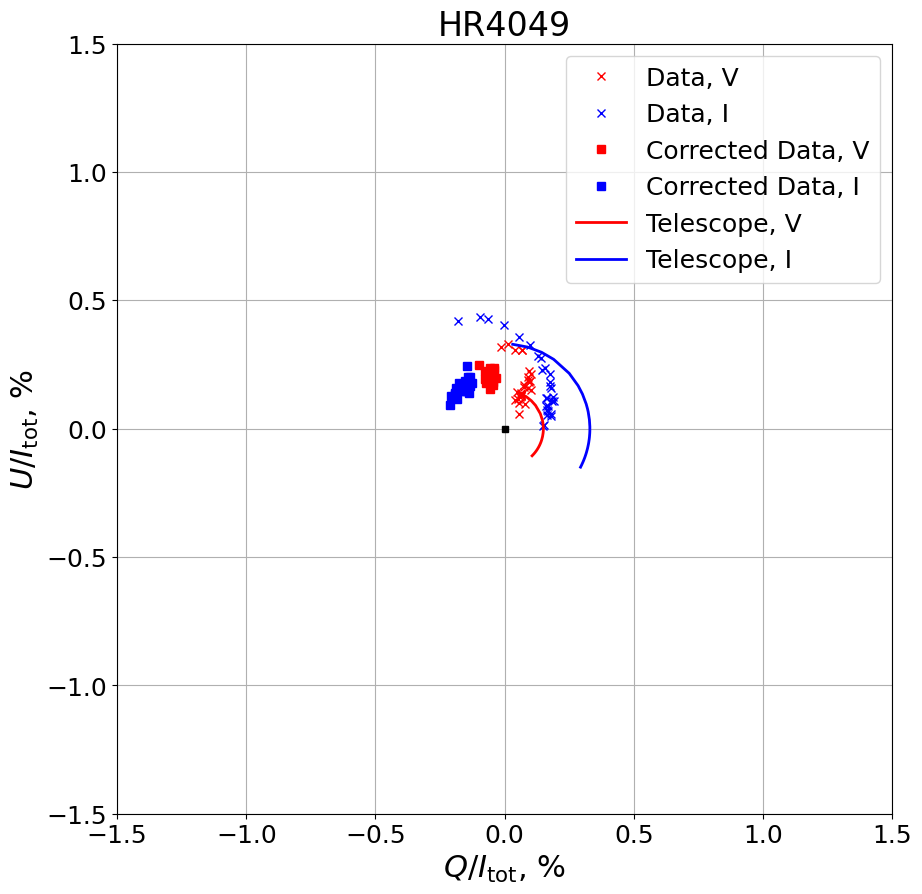

In [3]:

for star in stars:
        
        
    #dirdat ='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper2/'+'mean_combined/'+star+'/selected/'  #For IRAS08
    dirdat ='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'filtered/'+star+'/selected/'  #For set of stars
    input_filename =dirdat+'filtered_process_list.csv'







    figfolder='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+ 'telescope_corr_HMS/'
    createfolder(figfolder)
    if itelcor==0:
        figfolder=figfolder+'justimage/'  
        createfolder(figfolder)
    

    fitsfolder=figfolder+ star+'/'
    createfolder(fitsfolder)




    table = pd.read_csv(input_filename)

    processes=table['process']

    reference={process:ref for process,ref in zip(table['process'], table['reference'])}
    process_dict={ref:process for process,ref in zip(table['process'], table['reference'])}

    print(process_dict)
    print(len(process_dict))

    ndata=len(process_dict)
    parang=[]
    filename1=[]
    filename2=[]
    process=[]
    #camera=1 or 2
    for proc in process_dict.values():
        dirName=dirdat+'cam1/'
        _,_,_,_,time,file1,parang_ind= load_files(dirName,proc)
        filename1.append(file1)
        parang.append(parang_ind)
        dirName=dirdat+'cam2/'
        _,_,_,_,time,file2,parang_ind= load_files(dirName,proc)
        filename2.append(file2)
        process.append(proc)
       
    
    #sorting the data by paralactic angle for better plotting later
    combined = sorted(zip(parang, filename1, filename2, process), key=lambda x: x[0])
    parang, filename1, filename2, process = zip(*combined)
    parang = list(parang)
    filename1 = list(filename1)
    filename2 = list(filename2)
    process = list(process)


    print(process)



    for aper in range(len(rin_list)):

        #Inner and outer radius for aperture measurements
        rout = rout_list[aper]
        rin = rin_list[aper]

        # Definition of measuring apertures
        # ---------------------------------
        # distance map for central star
        dist = np.zeros((1024,1024))
        phipi = np.zeros((1024,1024))
        xc = 511
        yc = 511

        for i in range(1024):
            for j in range(1024):
                dist[i, j] = np.sqrt((float(i - xc)**2 + float(j - yc)**2))
                phipi[i, j] = np.arctan2(xc - float(i), float(j - yc))


        # central star aperture annulus r=0-140
        # --------------------------------------

        #apring = np.zeros((1024, 1024), dtype=float)
        #apin = np.zeros((1024, 1024), dtype=float)
        #apout = np.zeros((1024, 1024), dtype=float)

        #apout[dist <= rout] = 1.0
        #apin[dist <= rin] = 1.0
        apring = (dist <= rout)*(dist >= rin)#apout - apin

        # Output arrays
        # -------------

        # photopolarimetric parameters cam1 and cam2
        fiq1 = np.zeros(ndata, dtype=float)
        fq1 = np.zeros(ndata, dtype=float)
        fiu1 = np.zeros(ndata, dtype=float)
        fu1 = np.zeros(ndata, dtype=float)
        qoveri1 = np.zeros(ndata, dtype=float)
        uoveri1 = np.zeros(ndata, dtype=float)
        p1 = np.zeros(ndata, dtype=float)
        theta1 = np.zeros(ndata, dtype=float)

        fiq2 = np.zeros(ndata, dtype=float)
        fq2 = np.zeros(ndata, dtype=float)
        fiu2 = np.zeros(ndata, dtype=float)
        fu2 = np.zeros(ndata, dtype=float)
        qoveri2 = np.zeros(ndata, dtype=float)
        uoveri2 = np.zeros(ndata, dtype=float)
        p2 = np.zeros(ndata, dtype=float)
        theta2 = np.zeros(ndata, dtype=float)

        # peak counts for central star
        maxfiq1 = np.zeros(ndata, dtype=float)
        maxfiu1 = np.zeros(ndata, dtype=float)
        maxfiq2 = np.zeros(ndata, dtype=float)
        maxfiu2 = np.zeros(ndata, dtype=float)

        # azimuthal polarization cam1 and cam2
        fqphi1 = np.zeros(ndata, dtype=float)
        fuphi1 = np.zeros(ndata, dtype=float)
        fqphi2 = np.zeros(ndata, dtype=float)
        fuphi2 = np.zeros(ndata, dtype=float)
        qphioveri1 = np.zeros(ndata, dtype=float)
        uphioveri1 = np.zeros(ndata, dtype=float)
        qphioveri2 = np.zeros(ndata, dtype=float)
        uphioveri2 = np.zeros(ndata, dtype=float)

        # Derived for 2018 in ~/Paper/ZIMPOLTelPol/AnalysisTelPol.txt
            # ptel(mean) V, R, I: 0.146474, 0.177758, 0.335467
            # theta_tel(mean) V, R, I: 43.6922, 47.6353, 52.5533    
        if itelcor == 1:
            ptel1 = 0.15 / 100.0
            deltapi1 = 43.7 * np.pi / 180.0
            ptel2 = 0.33 / 100.0
            deltapi2 = 52.6 * np.pi / 180.0

        # Files to be read
        # ----------------
        # array for paralactic angle of cycles
        parangpi = np.zeros(ndata, dtype=float)
        qtel1 = np.zeros(ndata, dtype=float)
        utel1 = np.zeros(ndata, dtype=float)
        qtel2 = np.zeros(ndata, dtype=float)
        utel2 = np.zeros(ndata, dtype=float)


        # Now read the FITS files in a loop
        for i in range(ndata):
            dirName=dirdat+'cam1/'
            iq1,q1,iu1,u1,_,_,_= load_files(dirName,str(process[i]))
            dirName=dirdat+'cam2/'
            iq2,q2,iu2,u2,_,_,_= load_files(dirName,str(process[i]))
            # Your further processing of in1 and in2 goes here
            if itelcor == 0:
                # selectig only part of the image that correspond to the apperture 'apring'
                iq1 = iq1 * apring
                q1 = q1 * apring
                iu1 = iu1 * apring
                u1 = u1 * apring

                iq2 = iq2 * apring
                q2 = q2 * apring
                iu2 = iu2 * apring
                u2 = u2 * apring

            elif itelcor == 1:
                # calculate offset for telescope polarization
                parangpi[i] = parang[i] * np.pi / 180.0
                qtel1[i] = ptel1 * np.cos(2.0 * (parangpi[i] + deltapi1))
                utel1[i] = ptel1 * np.sin(2.0 * (parangpi[i] + deltapi1))
                qtel2[i] = ptel2 * np.cos(2.0 * (parangpi[i] + deltapi2))
                utel2[i] = ptel2 * np.sin(2.0 * (parangpi[i] + deltapi2))

                # correct the Qs and Us for telescope polarization and offset
                iq1 = iq1 * apring
                q1 = (q1 - (qtel1[i] + q1off) * iq1) * apring
                iu1 = iu1 * apring
                u1 = (u1 - (utel1[i] + u1off) * iu1) * apring

                iq2 = iq2 * apring
                q2 = (q2 - (qtel2[i] + q2off) * iq2) * apring
                iu2 = iu2 * apring
                u2 = (u2 - (utel2[i] + u2off) * iu2) * apring

            # azimuthal polarization,Katya: formula a bit diff from what I usually use, because phi defined differently
            qphi1 = -q1 * np.cos(2.0 * phipi) - u1 * np.sin(2.0 * phipi)
            uphi1 = -q1 * np.sin(2.0 * phipi) + u1 * np.cos(2.0 * phipi)

            # Azimuthal polarization for camera 2
            qphi2 = -q2 * np.cos(2.0 * phipi) - u2 * np.sin(2.0 * phipi)
            uphi2 = -q2 * np.sin(2.0 * phipi) + u2 * np.cos(2.0 * phipi)

            # Cam1 aperture integration star
            fiq1[i] = np.sum(iq1)
            fq1[i] = np.sum(q1)
            fiu1[i] = np.sum(iu1)
            fu1[i] = np.sum(u1)
            qoveri1[i] = fq1[i] / fiq1[i]
            uoveri1[i] = fu1[i] / fiu1[i]
            p1[i] = np.sqrt(qoveri1[i] ** 2 + uoveri1[i] ** 2)
            theta1[i] = 0.5 * np.arctan2(uoveri1[i], qoveri1[i])

            # Azimuthal polarization for camera 1
            fqphi1[i] = np.sum(qphi1)
            fuphi1[i] = np.sum(uphi1)
            qphioveri1[i] = fqphi1[i] * 2.0 / (fiq1[i] + fiu1[i])
            uphioveri1[i] = fuphi1[i] * 2.0 / (fiq1[i] + fiu1[i])

            # Cam2 aperture integration star
            fiq2[i] = np.sum(iq2)
            fq2[i] = np.sum(q2)
            fiu2[i] = np.sum(iu2)
            fu2[i] = np.sum(u2)
            qoveri2[i] = fq2[i] / fiq2[i]
            uoveri2[i] = fu2[i] / fiu2[i]
            p2[i] = np.sqrt(qoveri2[i] ** 2 + uoveri2[i] ** 2)
            theta2[i] = 0.5 * np.arctan2(uoveri2[i], qoveri2[i])

            # Azimuthal polarization for camera 2
            fqphi2[i] = np.sum(qphi2)
            fuphi2[i] = np.sum(uphi2)
            qphioveri2[i] = fqphi2[i] * 2.0 / (fiq2[i] + fiu2[i])
            uphioveri2[i] = fuphi2[i] * 2.0 / (fiq2[i] + fiu2[i])

            # Peak stellar flux
            maxfiq1[i] = np.max(iq1)
            maxfiu1[i] = np.max(iu1)
            maxfiq2[i] = np.max(iq2)
            maxfiu2[i] = np.max(iu2)

            if ifileout == 1:
                # Corrected Q and U frames
                fits.writeto(fitsfolder+f'qcorr_{reference[process[i]]}_1.fits', q1, overwrite=True)
                fits.writeto(fitsfolder+f'ucorr_{reference[process[i]]}_1.fits', u1, overwrite=True)
                fits.writeto(fitsfolder+f'qcorr_{reference[process[i]]}_2.fits', q2, overwrite=True)
                fits.writeto(fitsfolder+f'ucorr_{reference[process[i]]}_2.fits', u2, overwrite=True)
                # Corrected Qphi and Uphi frames
                fits.writeto(fitsfolder+f'qphi_{reference[process[i]]}_1.fits', qphi1, overwrite=True)
                fits.writeto(fitsfolder+f'uphi_{reference[process[i]]}_1.fits', uphi1, overwrite=True)
                fits.writeto(fitsfolder+f'qphi_{reference[process[i]]}_2.fits', qphi2, overwrite=True)
                fits.writeto(fitsfolder+f'uphi_{reference[process[i]]}_2.fits', uphi2, overwrite=True)

            if ifileout == 2:
                # Output of polarized flux frames
                pi1 = np.sqrt(q1**2 + u1**2)
                pi2 = np.sqrt(q2**2 + u2**2)
                fits.writeto(fitsfolder+f'pi_{filename1[i][4:]}', pi1[411:611, 411:611], overwrite=True)
                fits.writeto(fitsfolder+f'pi_{filename2[i][4:]}', pi2[411:611, 411:611], overwrite=True)



        # Output
        # Aperture flux, Stellar peak flux, and Polarized flux
        print('\nCentral star: Aperture flux')
        print('nr ,    file1  ,    file2 ,   Iq/Iu,   fcam1,  fcam2,  rat cam1/cam2')
        for i in range(ndata):
            print(f'{i} ', filename1[i], ' ', filename2[i], ' Iq ', fiq1[i], fiq2[i], fiq1[i] / fiq2[i])
            print(f'{i} ', filename1[i], ' ', filename2[i], ' Iu ', fiu1[i], fiu2[i], fiu1[i] / fiu2[i])

        #Stellar peak flux, cam1, cam2, and ratios
        print('\nCentral star: peak stellar flux')
        print('nr ,    file1  ,    file2 ,   Iq/Iu,   max(fcam1),  max(fcam2),  rat max(cam1)/max(cam2)')
        for i in range(ndata):
            print(f'{i} ', filename1[i], ' ', filename2[i], ' Iq ', maxfiq1[i], maxfiq2[i], maxfiq1[i] / maxfiq2[i])
            print(f'{i} ', filename1[i], ' ', filename2[i], ' Iu ', maxfiu1[i], maxfiu2[i], maxfiu1[i] / maxfiu2[i])

        # Polarized flux, cam1, cam2, and ratios
        print('\nAperture polarimetry: Polarized flux Q, U, and p x I')
        print('nr ,  cam1  ,   Q  ,  U   , cam2  ,  Q   , U')
        for i in range(ndata):
            print(f'{i} cam1 {fq1[i]}, {fu1[i]}, {np.sqrt((fq1[i])**2 + (fu1[i])**2)}, cam2 {fq2[i]}, {fu2[i]}, {np.sqrt((fq2[i])**2 + (fu2[i])**2)}')

        # Fractional polarization, cam1
        print('\nAperture polarimetry cam1: Fractional polarization')
        print('nr ,  parang, Q/I [%] , U/I [%] , p [%] , theta [degr]')
        for i in range(ndata):
           # Fractional polarization for cam1
           print(f'{i}, {parang[i]}, {qoveri1[i]*100.:.2f}, {uoveri1[i]*100.:.2f}, {p1[i]*100.:.2f}, {theta1[i]*180./np.pi:.2f}')

        # Fractional polarization, cam2
        print('\nAperture polarimetry cam2: Fractional polarization')
        print('nr ,  parang, Q/I [%] , U/I [%] , p [%] , theta [degr]')
        for i in range(ndata):
           # Fractional polarization for cam2
           print(f'{i}, {parang[i]}, {qoveri2[i]*100.:.2f}, {uoveri2[i]*100.:.2f}, {p2[i]*100.:.2f}, {theta2[i]*180./np.pi:.2f}')

        # Output for Q-U plot, cam1
        print('\nCentral star, Cam1: Output for Q-U plot')
        print('nr ,  parang , Q/I [%] , U/I [%]')
        for i in range(ndata):
           # Q-U plot for cam1
           print(f'{i} , {parang[i]} , {qoveri1[i]*100.:.2f} , {uoveri1[i]*100.:.2f}')

        # Output for Q-U plot, cam2
        print('\nCentral star cam2: Output for Q-U plot')
        print('nr ,  parang,  Q/I [%] , U/I [%]')
        for i in range(ndata):
           # Q-U plot for cam2
           print(f'{i} , {parang[i]} , {qoveri2[i]*100.:.2f} , {uoveri2[i]*100.:.2f}')

        # Azimuthal polarization cam1
        print('\nAzimuthal polarization cam1')
        print('nr ,  max(Iq) , max(Iu) , Qphi/I [%] , Uphi/I [%]')
        for i in range(ndata):
           # Azimuthal polarization for cam1
           print(f'{i} , {maxfiq1[i]} , {maxfiu1[i]} , {qphioveri1[i]*100.:.2f} , {uphioveri1[i]*100.:.2f}')

        # Azimuthal polarization cam2
        print('\nAzimuthal polarization cam2')
        print('nr ,  max(Iq) , max(Iu) , Qphi/I [%] , Uphi/I [%]')
        for i in range(ndata):
           # Azimuthal polarization for cam2
           print(f'{i} , {maxfiq2[i]} , {maxfiu2[i]} , {qphioveri2[i]*100.:.2f} , {uphioveri2[i]*100.:.2f}')



         # Calculate mean values for cam1
        fi1mean = (np.mean(fiq1) + np.mean(fiu1)) / 2.
        fq1mean = np.mean(fq1)
        fu1mean = np.mean(fu1)
        qoveri1mean = fq1mean / np.mean(fiq1) * 100.
        uoveri1mean = fu1mean / np.mean(fiu1) * 100.

        # Calculate mean values for cam2
        fi2mean = (np.mean(fiq2) + np.mean(fiu2)) / 2.
        fq2mean = np.mean(fq2)
        fu2mean = np.mean(fu2)
        qoveri2mean = fq2mean / np.mean(fiq2) * 100.
        uoveri2mean = fu2mean / np.mean(fiu2) * 100.

        # Print mean values
        print('Mean values for aperture')
        print(f'rin = {rin}, rout = {rout}')
        print('')
        print('cam1: rin, rout, I , Q , U , Q/I [%], U/I [%]')
        print(rin, rout, fi1mean, fq1mean, fu1mean, qoveri1mean, uoveri1mean)
        print('cam2:')
        print(rin, rout, fi2mean, fq2mean, fu2mean, qoveri2mean, uoveri2mean)

        # Correct for telescope polarization if not already corrected
        if itelcor == 0:
            print(parang)
            parangpi = np.deg2rad(parang)#*np.pi/180

            print(' ')
            print('Parameters for telescope polarization')
            # Derived for 2018 in ~/Paper/ZIMPOLTelPol/AnalysisTelPol.txt
            # ptel(mean) V, R, I: 0.146474, 0.177758, 0.335467
            # theta_tel(mean) V, R, I: 43.6922, 47.6353, 52.5533
            ptel1 = 0.15 / 100.
            deltapi1 = 43.7 * np.pi / 180
            print('cam1', ptel1 * 100., deltapi1 * 180. / np.pi)
            qtel1 = ptel1 * np.cos(2. * (parangpi + deltapi1))
            utel1 = ptel1 * np.sin(2. * (parangpi + deltapi1))

            # Filter camera 2 (Cnt820)
            ptel2 = 0.33 / 100.
            deltapi2 = 52.6 * np.pi / 180
            print('cam2', ptel2 * 100., deltapi2 * 180. / np.pi)
            qtel2 = ptel2 * np.cos(2. * (parangpi + deltapi2))
            utel2 = ptel2 * np.sin(2. * (parangpi + deltapi2))

            # Corrected data points
            qcorr1 = qoveri1 - qtel1
            ucorr1 = uoveri1 - utel1
            qcorr2 = qoveri2 - qtel2
            ucorr2 = uoveri2 - utel2

            print('Corrected data points')
            print('cam1, qcorr, ucorr, cam2: qcorr, ucorr')
            print('mean', np.mean(qcorr1) * 100., np.mean(ucorr1) * 100., np.mean(qcorr2) * 100., np.mean(ucorr2) * 100.)
            print('stdev', np.std(qcorr1) * 100., np.std(ucorr1) * 100., np.std(qcorr2) * 100., np.std(ucorr2) * 100.)


            # Plot settings
            plt.figure(figsize=(10,10))
            plt.title(starnames[star], fontsize=24)
            plt.xlabel(r'$Q/I_{\rm tot}$, %', fontsize=22)
            plt.ylabel(r'$U/I_{\rm tot}$, %', fontsize=22)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            
            if star=='IRAS08544-4431_dc_notnorm' or star=='IRAS08544-4431' or stars_type[star]=='sci':
                plt.xlim(-1.5, 1.5)
                plt.ylim(-1.5, 1.5)
            elif star=='HD83878'or stars_type[star]=='ref':
                #to make scale same as for IRAS08
                #plt.xlim(-2, 3)
                #plt.ylim(-2, 3)
                #to make it actually visible
                plt.xlim(-1, 1)
                plt.ylim(-1, 1)
            if star=='AR_Pup_dc_notnorm':
                plt.xlim(-2, 2)
                plt.ylim(-2, 2)
            if star=='V709_Car':
                plt.xlim(-1, 2)
                plt.ylim(-5, 1)

            plt.plot(qoveri1 * 100, uoveri1 * 100, 'x', label='Data, V', markersize=6,color='red')
            plt.plot(qoveri2 * 100, uoveri2 * 100, 'x', label='Data, I', markersize=6,color='blue')

            # Lines
            #plt.plot(qoveri1 * 100, uoveri1 * 100, 'r-', label='Data 1')
            #plt.plot(qoveri2 * 100, uoveri2 * 100, 'b-', label='Data 2')


            # Additional point
            plt.plot(0, 0, 's', markersize=4,color='black')

            # Corrected data points
            plt.plot(qcorr1 * 100, ucorr1 * 100, 's', label='Corrected Data, V', markersize=6 ,color='red')
            plt.plot(qcorr2 * 100, ucorr2 * 100, 's', label='Corrected Data, I', markersize=6 ,color='blue')

            # Calculated or applied correction for the telescope polarization
            plt.plot(qtel1 * 100, utel1 * 100, label='Telescope, V', color='red', linewidth=2,linestyle='solid')
            plt.plot(qtel2 * 100, utel2 * 100, label='Telescope, I', color='blue', linewidth=2,linestyle='solid')

            plt.legend(loc='best', fontsize=18)
            plt.grid(True,which='both')
            plt.savefig(fitsfolder+f'{star}corr_{rin}_{rout}.png', dpi=500)
            plt.show()

            plt.close()


